In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

from PLred.visPLred import couplingmap as cm

In [2]:
import importlib
importlib.reload(cm)

<module 'PLred.visPLred.couplingmap' from '/home/first/yjkim/PLred/PLred/visPLred/couplingmap.py'>

In [3]:
firstcam_timestamp_path = '/mnt/datazpool/PL/20240917/firstpl/'
firstcam_spec_path =      '/mnt/datazpool/PL/yjkim/reduced/betcmi_20240917/'
obs_start = '14:55:00'
obs_end   = '15:10:00'


psfcam = 'palila'
psfcam_frames_name = '/mnt/datazpool/PL/yjkim/reduced/betcmi_20240917/first_palila_matched_fastcam_matched_frames.npy'
psfcam_timestamp_name = '/mnt/datazpool/PL/yjkim/reduced/betcmi_20240917/first_palila_matched.pkl'

sd = cm.SimultaneousData(firstcam_timestamp_path, firstcam_spec_path,
                 obs_start, obs_end,
                 psfcam, 
                 psfcam_frames_name, psfcam_timestamp_name)

number of files found: 45
number of files found: 45
Timestamp1 start: 2024-09-17 14:55:17.051555, end 2024-09-17 15:10:17.427883, length 45000 
Timestamp2 start: 2024-09-17 14:35:36.532216, end 2024-09-17 15:09:46.114151, length 102435 
Filtered 1565 out of timestamp1, 59000 out of timestamp2


In [4]:
sd.compute_psfcam_centroids(peak=True)


/home/first/miniconda3/envs/sklearn-env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/first/miniconda3/envs/sklearn-env/lib/python3.13/site-packages/numpy/_core/_methods.py:137: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


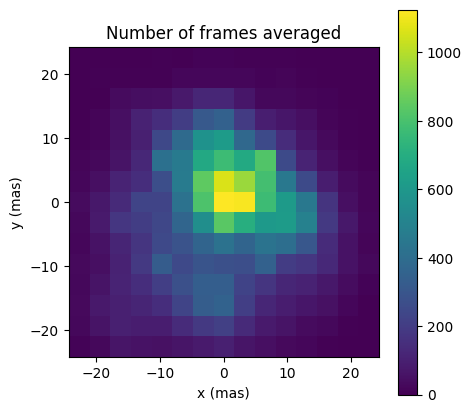

In [5]:
sd.bin_by_centroids(15, 3, calculate_variance = False)


(array([7.0000e+00, 5.1000e+01, 1.2900e+02, 4.7900e+02, 6.1240e+03,
        2.3837e+04, 1.1826e+04, 7.7200e+02, 1.9400e+02, 1.6000e+01]),
 array([16.41927641, 17.24462775, 18.06997908, 18.89533042, 19.72068176,
        20.54603309, 21.37138443, 22.19673577, 23.02208711, 23.84743844,
        24.67278978]),
 <BarContainer object of 10 artists>)

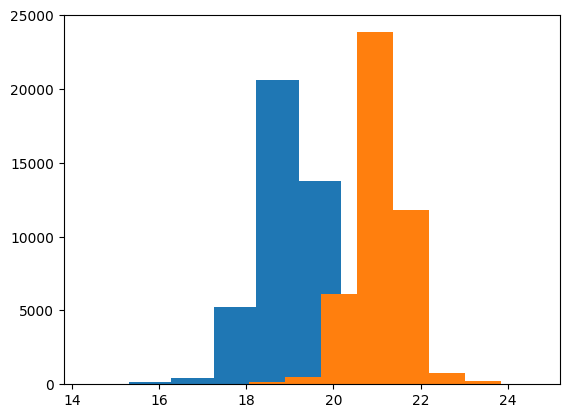

In [6]:
plt.hist(sd.centroids[:,0])
plt.hist(sd.centroids[:,1])

In [7]:
map_width = 3
map_n = 15
xbins = np.linspace(np.nanmedian(sd.centroids[:,0]) - map_width/2, np.nanmedian(sd.centroids[:,0]) + map_width/2, map_n+1)
ybins = np.linspace(np.nanmedian(sd.centroids[:,1]) - map_width/2, np.nanmedian(sd.centroids[:,1]) + map_width/2, map_n+1)


In [8]:

def bin_by_centroids_distribution(firstcamframes, centroids, xbins, ybins):
    '''
    Bin frames by centroids
    '''
    x = centroids[:,0]
    y = centroids[:,1]

    # psfcam_binned_frames = np.zeros((len(xbins)-1, len(ybins)-1, psfcamframes.shape[1], psfcamframes.shape[2]))
    # firstcam_binned_frames = np.zeros((len(xbins)-1, len(ybins)-1, firstcamframes.shape[1], firstcamframes.shape[2]))
    # num_frames = np.zeros((len(xbins)-1, len(ybins)-1))
    idxs = np.zeros((len(xbins)-1, len(ybins)-1, len(firstcamframes)), dtype=bool)

    firstcam_binned_list = []
    
    for i in range(len(xbins)-1):
        for j in range(len(ybins)-1):
            xidx = (x >= xbins[i]) & (x < xbins[i+1])
            yidx = (y >= ybins[j]) & (y < ybins[j+1])
            idx = xidx & yidx
            idxs[i,j] = idx

            firstcam_binned_list.append(firstcamframes[idx, :, 108])

            # psfcam_binned_frames[i,j] = np.mean(psfcamframes[idx], axis=0)
            # firstcam_binned_frames[i,j] = np.mean(firstcamframes[idx], axis=0)
            # num_frames[i,j] = np.sum(idx)
    return firstcam_binned_list #psfcam_binned_frames, firstcam_binned_frames, num_frames, idxs



In [9]:
binned_list = bin_by_centroids_distribution(sd.firstcam_frames, sd.centroids, xbins, ybins)

In [10]:
len(binned_list[1])

26

In [11]:
np.shape(sd.firstcam_frames)

(43435, 38, 200)

In [165]:
vals = sd.firstcam_frames[:,:,108].T



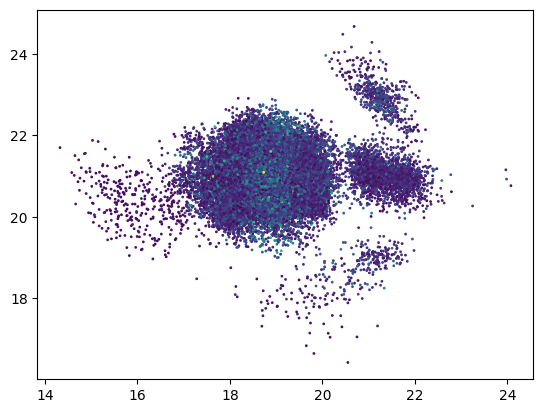

In [167]:
plt.scatter(sd.centroids[:,0], sd.centroids[:,1], c=vals[2], s=1)

(np.float64(4.999999999992486), np.float64(6.999999999992484))


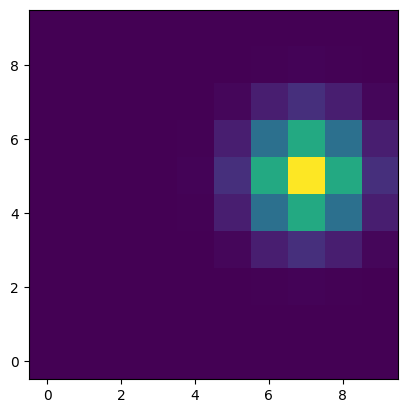

In [187]:
from astropy.modeling.functional_models import Gaussian2D
xg, yg = np.meshgrid(np.arange(10), np.arange(10))#, indexing='ij')

g = Gaussian2D(amplitude=1, x_mean=7, y_mean=5, x_stddev=1, y_stddev=1)
plt.imshow(g(xg, yg), origin='lower')#, extent=(0, 10, 0, 10))

from PLred.imageutils import subpixel_centroid_2d
print(subpixel_centroid_2d(g(xg, yg)))

In [169]:
medpoint = np.median(sd.centroids, axis=0)
print(medpoint)

[19.05182783 21.09600221]


In [170]:
shifted_centroids = sd.centroids - medpoint
framemask = ~(~(shifted_centroids[:,0] > -1.5) + ~(shifted_centroids[:,0] < 1.5)+ ~(shifted_centroids[:,1] > -1.5) + ~(shifted_centroids[:,1] < 1.5))
filtered_centroids = shifted_centroids[framemask]

In [171]:
framemask = (
    (shifted_centroids[:, 0] > -map_width / 2) &
    (shifted_centroids[:, 0] <  map_width / 2) &
    (shifted_centroids[:, 1] > -map_width / 2) &
    (shifted_centroids[:, 1] <  map_width / 2)
)

In [172]:
np.sum(framemask)

np.int64(38911)

In [173]:
np.shape(filtered_centroids[::-1])

(38911, 2)

In [174]:
filtered_centroids[:,::-1][0]

array([-0.2862694 ,  0.36110006])

In [175]:
filtered_centroids[0]


array([ 0.36110006, -0.2862694 ])

In [176]:
from sklearn.cluster import KMeans

n_per_bin = 100
n_clusters = len(filtered_centroids) // n_per_bin
kmeans = KMeans(n_clusters = n_clusters, random_state=0, n_init = 'auto').fit(filtered_centroids[:,::-1])

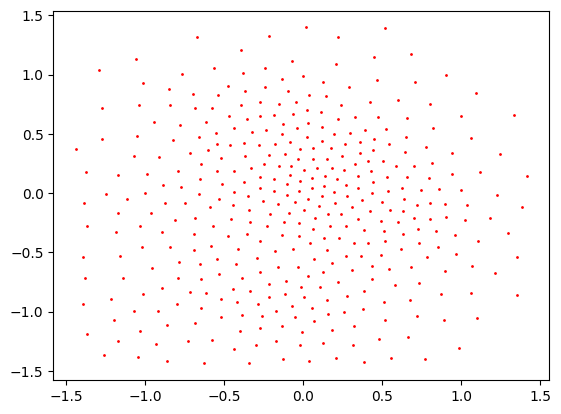

In [177]:
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], c='red', s=1)


In [178]:
kmeans.n_clusters

389

In [190]:
vor

In [ ]:
vor.

In [179]:
vals = sd.firstcam_frames[framemask,:,108].T


In [180]:
np.shape(vals)

(38, 38911)

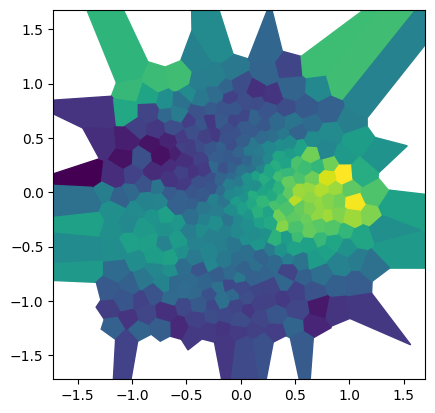

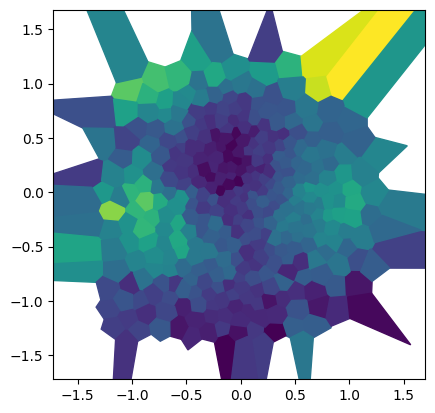

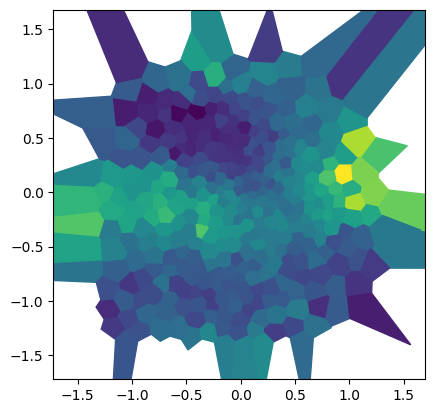

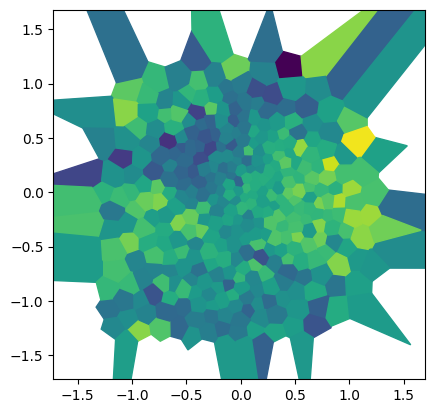

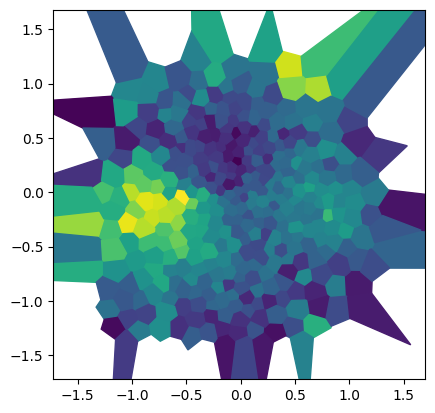

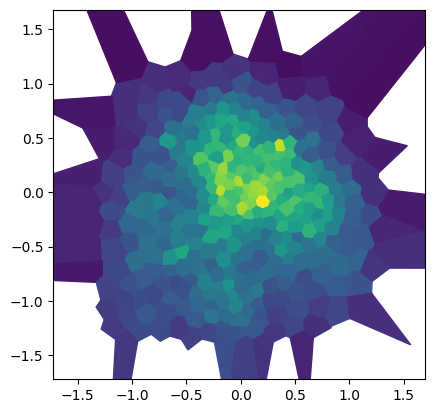

In [181]:
# compute the means for each bin
mv = np.empty((n_clusters,vals.shape[0]),dtype=float)
for i in range(n_clusters):
    w = np.nonzero(kmeans.labels_ == i)[0]
    mv[i,:] = vals[:,w].mean(axis=1)

# compute the standard deviation for each bin
sv = np.empty((n_clusters,vals.shape[0]),dtype=float)
for i in range(n_clusters):
    w = np.nonzero(kmeans.labels_ == i)[0]
    sv[i,:] = vals[:,w].std(axis=1)

# compute number of points in each bin
n_points = np.empty((n_clusters,),dtype=int)
for i in range(n_clusters):
    n_points[i] = len(np.nonzero(kmeans.labels_ == i)[0])
# print(n_points)

# visualize with voronoi via delaunay triangulation
from scipy.spatial import Voronoi, voronoi_plot_2d
vor = Voronoi(kmeans.cluster_centers_)
#fig = voronoi_plot_2d(vor)


def show_voronoi(vor, vv, ax=None, minima = None, maxima = None):
    if ax is None:
        ax = plt.subplot(111)
    # find min/max values for normalization
    if minima is None: minima = min(vv)
    if maxima is None: maxima = max(vv)
    
    # normalize chosen colormap
    import matplotlib as mpl
    import matplotlib.cm as cm
    norm = mpl.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
    mapper = cm.ScalarMappable(norm=norm, 
                               #cmap=cm.Blues_r,
                            #    cmap=cm.gray,
                              )
    
    # plot Voronoi diagram, and fill finite regions with color mapped from speed value
    voronoi_plot_2d(vor, ax=ax,
                    #show_points=True, 
                    show_points=False,
                    show_vertices=False, 
                    line_width=0,
                    s=1,
                    origin='upper'
                    )
    for r in range(len(vor.point_region)):
        region = vor.regions[vor.point_region[r]]
        if not -1 in region:
            polygon = [vor.vertices[i] for i in region]
            plt.fill(*zip(*polygon), color=mapper.to_rgba(vv[r]))
    #plt.show()
    return ax

for i in range(3):
    ax = show_voronoi(vor, mv[:,i])
    ax.set_aspect('equal')
    # ax.set_xlim([medpoint[0]-1.5, medpoint[0]+1.5])
    # ax.set_ylim([medpoint[1]-1.5, medpoint[1]+1.5])
    plt.show()

for i in range(2):
    ax = show_voronoi(vor, sv[:,i])
    ax.set_aspect('equal')
    # ax.set_xlim([medpoint[0]-1.5, medpoint[0]+1.5])
    # ax.set_ylim([medpoint[1]-1.5, medpoint[1]+1.5])
    plt.show()

ax = show_voronoi(vor, n_points)
ax.set_aspect('equal')
# ax.set_xlim([medpoint[0]-1.5, medpoint[0]+1.5])
# ax.set_ylim([medpoint[1]-1.5, medpoint[1]+1.5])
plt.show()

<Axes: >

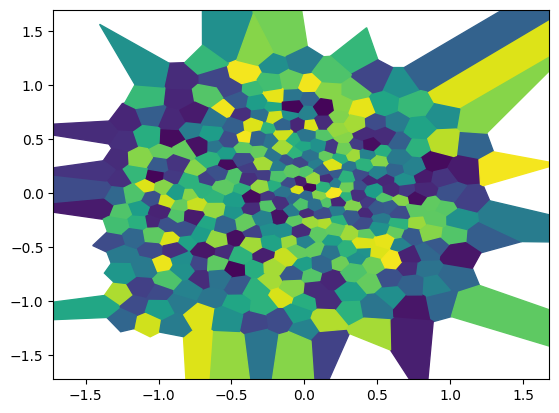

In [132]:
show_voronoi(vor ,kmeans.labels_)

In [133]:
n_clusters

389

In [134]:
vor.npoints

389

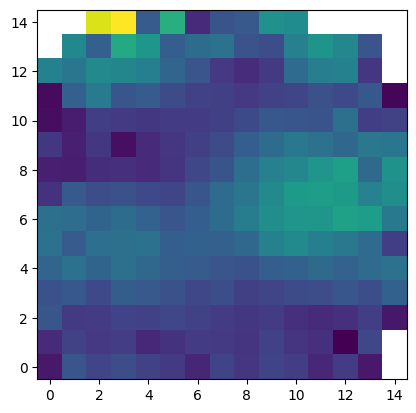

In [163]:
plt.imshow(sd.firstcam_binned_frames[:,:,0,108], origin='lower')

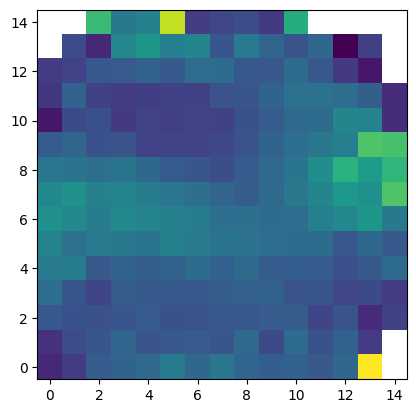

In [182]:
plt.imshow(sd.firstcam_binned_frames[:,:,2,108], origin='lower')


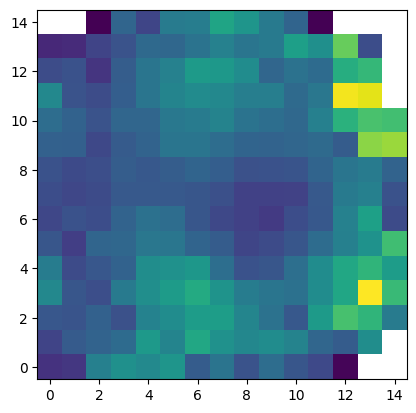

In [110]:
plt.imshow(sd.firstcam_binned_frames[:,:,1,108].T, origin='lower')


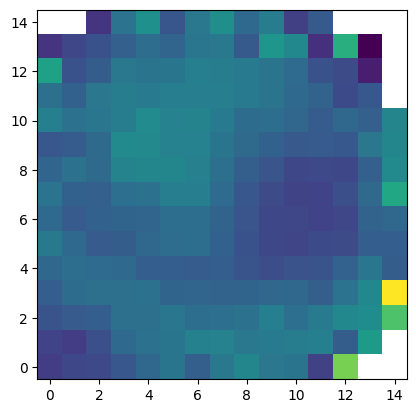

In [111]:
plt.imshow(sd.firstcam_binned_frames[:,:,4,105].T, origin='lower')


In [112]:
def make_interpolation_model_irregular(normcube, points_x, points_y, wav_fitrange, wav_reconrange, 
                             poly_deg_spatial = 7, poly_deg_spectral = 7,
                             variance_map = None, weighted = True):
    '''
    Make a polynomial interpolation model for the coupling map data.

    Parameters
    ----------
    normcube : np.ndarray
        normalized cube data with shape (n_x, n_y, n_wav)
    pos_mas : np.ndarray
        positions in milliarcseconds (mas) for the spatial grid
    wav_fitrange : list
        wavelength range for fitting the polynomial
    wav_reconrange : list
        wavelength range for reconstructing the polynomial
    poly_deg_spatial : int
        degree of the polynomial in spatial direction
    poly_deg_spectral : int
        degree of the polynomial in spectral direction
    variance_map : np.ndarray, optional
        variance map for weighted least squares, should have the same shape as normcube
    weighted : bool
        if True, use weighted least squares

    Returns
    -------
    modeled_coeffs : np.ndarray
        coefficients of the polynomial model with shape (n_wav, n_coeffs)
    modeled_recon : np.ndarray
        reconstructed data with shape (n_x, n_y, n_wav)
    all_map_input : np.ndarray
        input data for the polynomial model with shape (n_x, n_y, n_wav)
    '''

    if weighted is True: assert variance_map is not None, "for weighted least squares, variance map should be given"

    all_recon_data, all_map_input, all_coeffs = [], [], []

    # x_grid, y_grid = np.meshgrid(pos_mas, pos_mas)

    # x_flat = x_grid.ravel()
    # y_flat = y_grid.ravel()

    from PLred.mapmodel import poly_design_matrix
    from scipy.linalg import lstsq
    
    X_poly = poly_design_matrix(points_x, points_y, poly_deg_spatial)

    _wav_fitrange_inds = []
    for ii, specind in enumerate(wav_reconrange):
        # iterate over the spectral indices in the recon range

        map_data = normcube[:,specind] # cube[:,:,specind] / np.nansum(cube[:,:,specind])
        weight = 1/variance_map[:,specind]
        idx = ~np.isfinite(map_data)
        map_data[idx] = 0
        weight[idx] = 0

        reshaped_data = map_data.ravel()
        
        if weighted:
            reshaped_weights = weight.ravel() #* 0 + 1.0
        else:
            reshaped_weights = np.ones_like(reshaped_data)



        X_poly_weighted = X_poly * np.sqrt(reshaped_weights[:,np.newaxis])
        b_weighted = reshaped_data * np.sqrt(reshaped_weights)

        coeffs, _, _, _ = lstsq(X_poly_weighted, b_weighted)
        
        recon = np.dot(X_poly, coeffs)

        # reshape to match the cube
        # recon = recon.reshape((len(pos_mas), len(pos_mas)))
        # map_input = reshaped_data.reshape((len(pos_mas), len(pos_mas)))

        all_recon_data.append(recon)
        all_map_input.append(reshaped_data)
        
        # store the coefficients
        all_coeffs.append(coeffs)
        if specind in wav_fitrange:
            _wav_fitrange_inds.append(ii)
    
    _wav_fitrange_inds = np.array(_wav_fitrange_inds)

    all_coeffs = np.array(all_coeffs)
    modeled_coeffs = np.zeros_like(all_coeffs)

    _wav_reconrange_inds = []
    for ii, coeff_ind in enumerate(range(np.shape(all_coeffs)[1])):
        # polynomial fit of the coefficients along the wavelength range (fitrange) and store the interpolated coefficients in reconrange
        poly = np.polyfit(wav_fitrange, all_coeffs[_wav_fitrange_inds,coeff_ind], deg = poly_deg_spectral)
        modeled_coeff = np.poly1d(poly)(wav_reconrange)
        modeled_coeffs[:,coeff_ind] = modeled_coeff
        _wav_reconrange_inds.append(ii)

    modeled_recon = []
    for ii, specind in enumerate(wav_reconrange):
        # compute the modeled reconstruction for each spectral index in the recon range
        recon = np.dot(X_poly, modeled_coeffs[ii])
        # recon = np.dot(X_poly, modeled_coeffs[specind])
        modeled_recon.append(recon)#.reshape((len(pos_mas), len(pos_mas))))

    modeled_recon = np.array(modeled_recon)

    all_map_input = np.array(all_map_input)

    # # fill in the missing values
    # missing_indices_x = np.where(idx == True)[0]
    # missing_indices_y = np.where(idx == True)[1]

    # for (mx, my) in zip(missing_indices_x, missing_indices_y):
    #     (all_map_input)[:,mx, my] = modeled_recon[:,mx, my]

    return modeled_coeffs, modeled_recon, all_map_input





In [114]:
mv = np.empty((n_clusters,38, 200),dtype=float)

for specind in range(200):
    vals = sd.firstcam_frames[framemask,:,specind].T
    for i in range(n_clusters):
        w = np.nonzero(kmeans.labels_ == i)[0]
        mv[i,:,specind] = vals[:,w].mean(axis=1)



In [135]:
kmeans.labels_

array([297, 249, 367, ..., 171,  79, 138], shape=(38911,), dtype=int32)

In [141]:
np.shape(n_points)

(389,)

In [143]:
kmeans.labels_

array([297, 249, 367, ..., 171,  79, 138], shape=(38911,), dtype=int32)

In [136]:
np.unique(kmeans.labels_)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [115]:
np.shape(mv)

(389, 38, 200)

In [116]:
norm_mv = mv / np.nansum(mv, axis=0)[None]

In [117]:
np.shape(norm_mv)


(389, 38, 200)

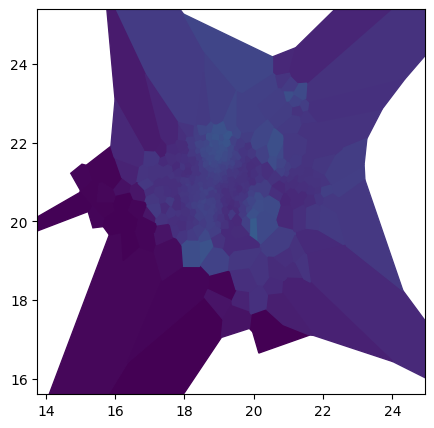

In [48]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)

def animate(specind):
    ax.clear()
    show_voronoi(vor, norm_mv[:,0,specind], ax, minima = 0, maxima = 0.015)
    

from matplotlib.animation import FuncAnimation
from IPython.display import HTML

anim = FuncAnimation(fig, animate, frames=np.arange(90,120), interval=100)
HTML(anim.to_jshtml())

In [38]:
np.shape(sd.firstcam_binned_frames)

(15, 15, 38, 200)

In [118]:
np.shape(norm_mv)

(389, 38, 200)

In [ ]:
normdata = 

In [119]:
modeled_coeffs, modeled_recon, all_map_input = make_interpolation_model_irregular(norm_mv[:,0,:], 
                        points_x = kmeans.cluster_centers_[:,0],
                        points_y = kmeans.cluster_centers_[:,1], 
                        wav_fitrange = np.r_[0:100, 120:200], 
                        wav_reconrange = np.r_[0:200],
                        poly_deg_spatial = 9,
                        poly_deg_spectral = 9,
                        variance_map= np.ones_like(norm_mv[:,0,:]),
                        weighted = True)

In [120]:
modeled_recon

array([[0.0021478 , 0.00270273, 0.00330313, ..., 0.00307012, 0.00202644,
        0.00287204],
       [0.00214756, 0.00269901, 0.00329992, ..., 0.00302934, 0.00202578,
        0.00286821],
       [0.00214776, 0.00269467, 0.00329546, ..., 0.00299671, 0.00202576,
        0.00286479],
       ...,
       [0.00258923, 0.00273463, 0.00338116, ..., 0.00367314, 0.00175907,
        0.00260476],
       [0.00259233, 0.0027381 , 0.0033841 , ..., 0.00367322, 0.00176102,
        0.00259996],
       [0.00259592, 0.00274222, 0.00338683, ..., 0.0036687 , 0.00176401,
        0.00259458]], shape=(200, 389))

In [121]:
np.shape(norm_mv[:,0,:])

(389, 200)

<Axes: >

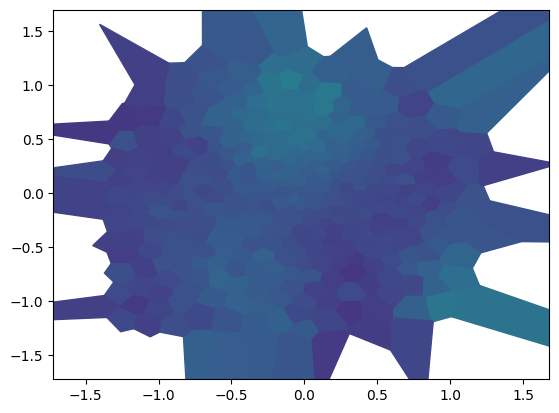

In [122]:
show_voronoi(vor, norm_mv[:,0,100], minima = 0, maxima = 0.01)


<Axes: >

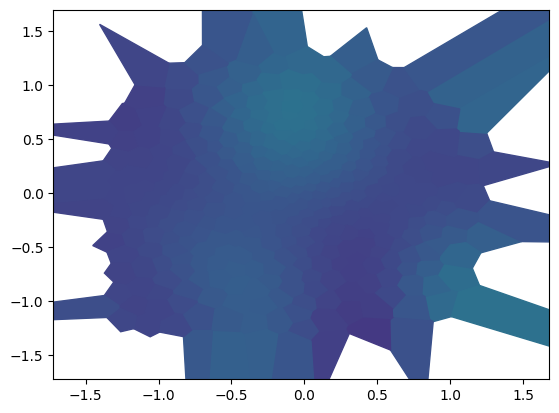

In [123]:
show_voronoi(vor, modeled_recon[100], minima = 0, maxima = 0.01)

In [126]:
np.shape(norm_mv)

(389, 38, 200)

<Axes: >

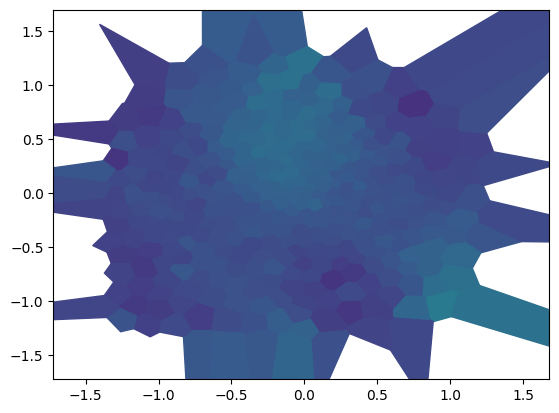

In [128]:
show_voronoi(vor, norm_mv[:,0,0], minima = 0, maxima = 0.010)


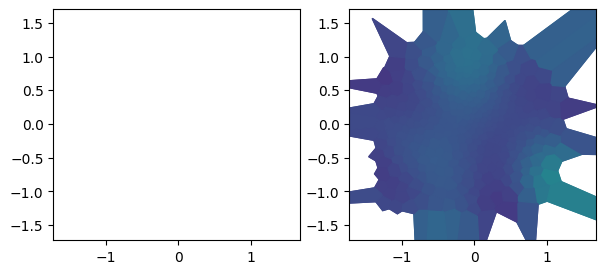

In [129]:
fig, axs = plt.subplots(ncols=2,figsize=(7,3))

def animate(specind):
    for ax in axs: ax.clear()
    show_voronoi(vor, norm_mv[:,0,specind], ax=axs[0], minima = 0, maxima = 0.010)
    show_voronoi(vor, modeled_recon[specind], ax=axs[1], minima = 0, maxima = 0.010)
    

from matplotlib.animation import FuncAnimation
from IPython.display import HTML

anim = FuncAnimation(fig, animate, frames=np.arange(60,80), interval=100)
HTML(anim.to_jshtml())

In [ ]:
import PLred.mapmodel as mm
mapmodel = mm.CouplingMapModel()

In [24]:
np.shape(sd.firstcam_binned_frames)

(15, 15, 38, 200)

In [22]:
np.shape(binned_list[2])

(11, 38)

In [7]:
sd.centroids

array([[19.16341027, 19.39377415],
       [19.17480611, 19.4353695 ],
       [18.46309431, 19.77811213],
       ...,
       [19.08838671, 21.5819784 ],
       [19.24887929, 21.12805414],
       [19.80080484, 20.83986327]], shape=(30000, 2))

In [8]:
sd.firstcam_binned_frames

array([[[[ 975.03650778,  963.60237142,  829.68693427, ...,
           248.85011289,  292.0636153 ,  397.73638104],
         [ 483.66517865,  342.43460926,  523.45040436, ...,
           215.41764646,  409.6078514 ,  787.84227201],
         [ 770.02716071,  585.45692735,  503.71996291, ...,
           179.89680811,  222.00825595,  296.34202795],
         ...,
         [ 293.37134658,  318.55278499,  179.67265601, ...,
            61.81412541,   70.32955817,   92.96940354],
         [1054.86936217,  754.72170507,  470.24734726, ...,
           133.29292352,  215.20464594,  229.80020637],
         [ 593.99261237,  333.06264254,  153.39158195, ...,
           168.04788207,  202.85466835,  303.28084762]],

        [[ 670.39766446,  725.06989453,  617.75367108, ...,
           347.34390121,  380.3479542 ,  511.12850369],
         [ 610.50756412,  368.44334627,  454.63255125, ...,
           170.34144688,  239.97108284,  507.96823684],
         [ 431.52379967,  409.23397595,  256.56535941, .